# Imports

In [119]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [184]:
def calculate_metrics(conf_matrix):
    TP = conf_matrix[0][0]
    FN = conf_matrix[0][1]
    FP = conf_matrix[1][0]
    TN = conf_matrix[1][1]

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)

    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    metrics = {
        'TP': TP, 
        'TN': TN, 
        'FP': FP, 
        'FN': FN, 
        'TPR': TPR, 
        'TNR': TNR, 
        'FPR': FPR, 
        'FNR': FNR, 
        'Precision': Precision, 
        'F1_measure': F1_measure, 
        'Accuracy': Accuracy, 
        'Error_rate': Error_rate, 
        'BACC': BACC, 
        'TSS': TSS, 
        'HSS': HSS}
    return metrics

# Get Data

In [124]:
obesity_data = pd.read_csv('obesity_data.csv')
obesity_data.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


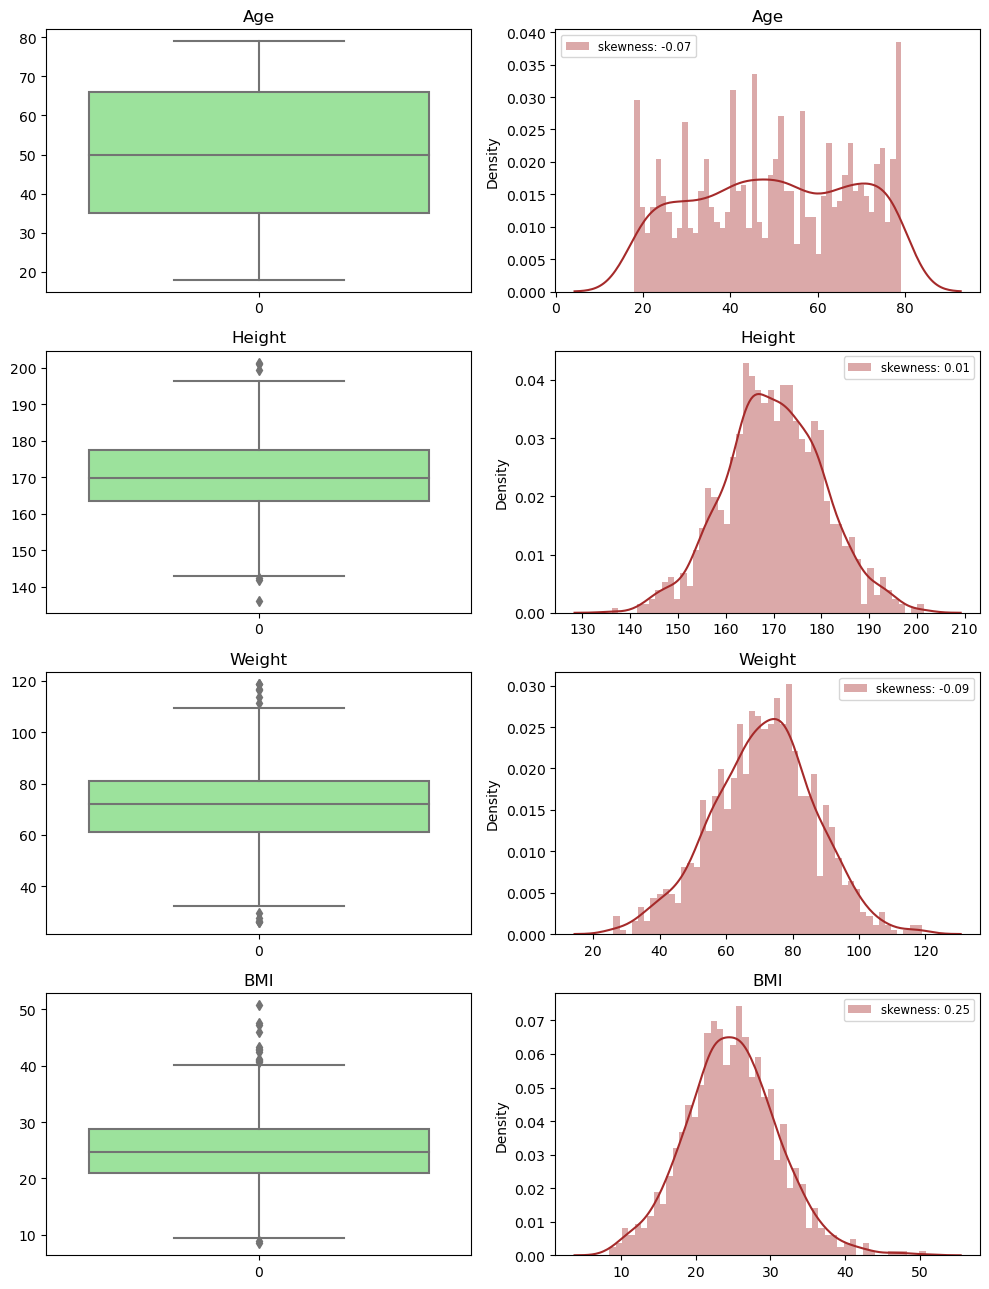

In [126]:
num_cols = obesity_data.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 13))
axes = axes.flatten()

for i, col in enumerate(num_cols[:-1]):
    ax1 = axes[i * 2]
    ax2 = axes[i * 2 + 1]

    sns.boxplot(data=obesity_data[col], ax=ax1, color="lightgreen")
    ax1.set_title(col)

    sns.distplot(obesity_data[col], ax=ax2, color="brown", bins=50, label=f"skewness: {obesity_data[col].skew().round(2)}")
    ax2.set_title(col)
    ax2.set_xlabel("")
    ax2.legend(fontsize="small")

plt.tight_layout()
plt.show()

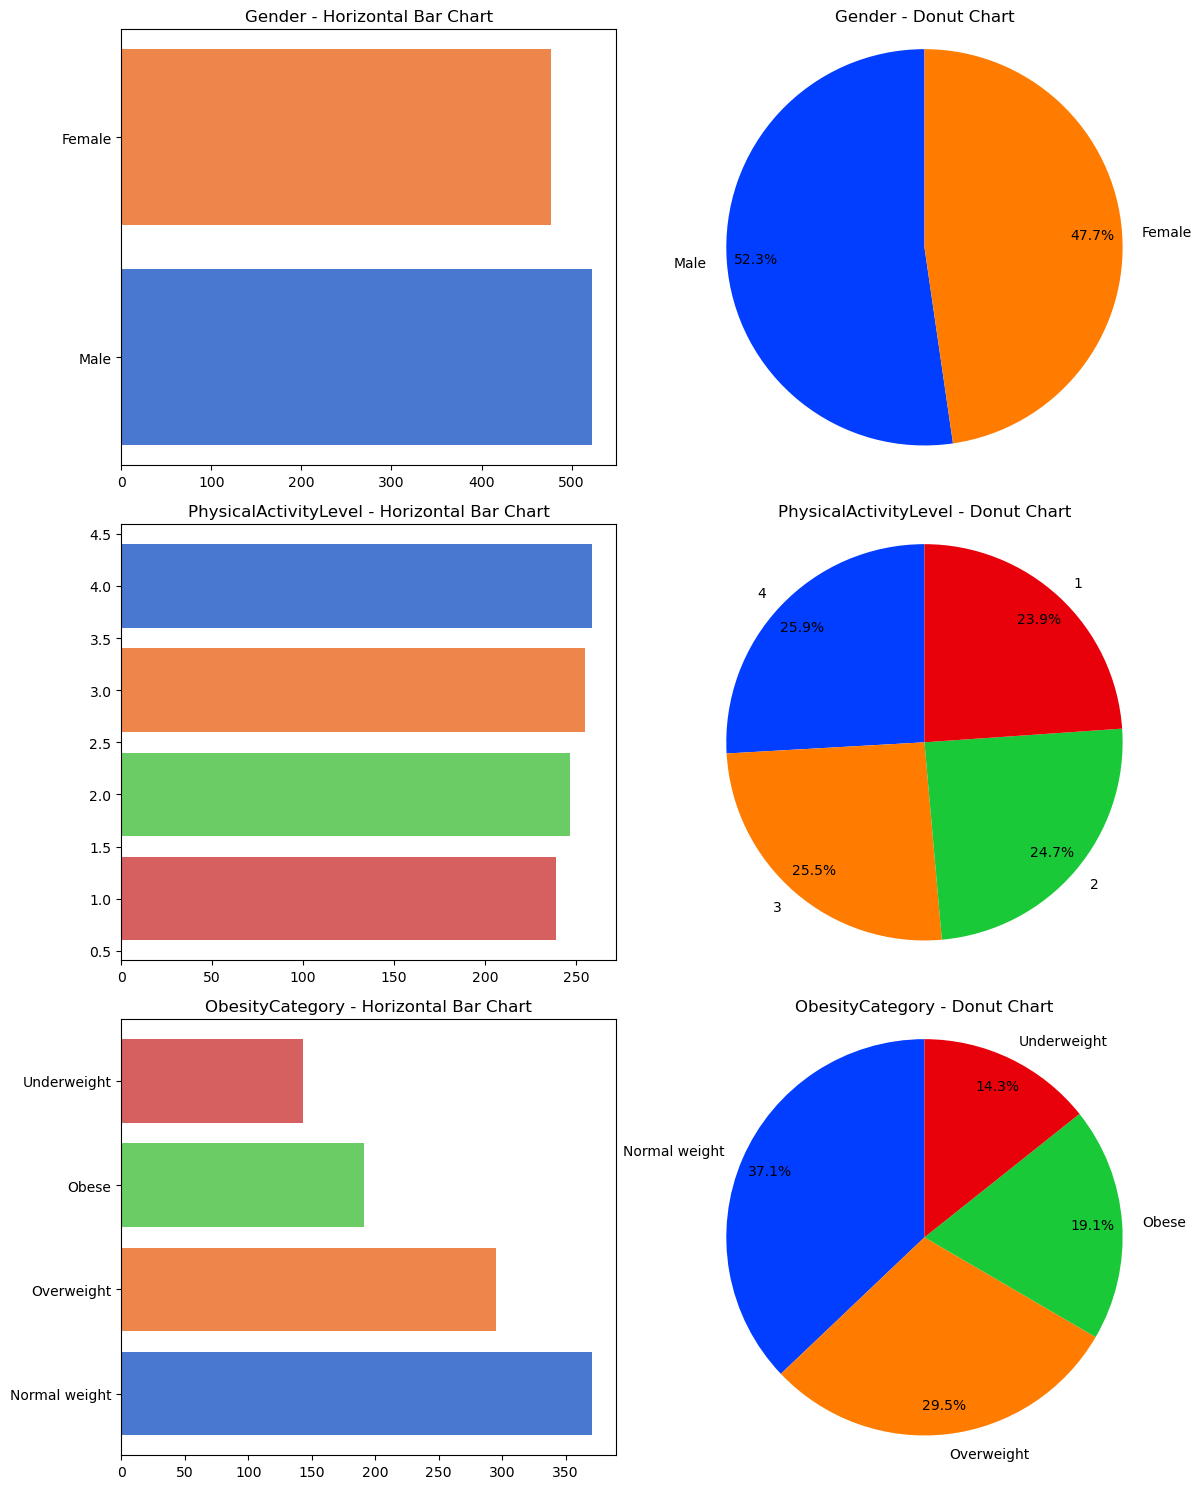

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

categorical_cols = ["Gender", "PhysicalActivityLevel", "ObesityCategory"]

for i, col in enumerate(categorical_cols):
    ax1, ax2 = axes[i * 2], axes[i * 2 + 1]

    # Horizontal bar chart
    value_counts = obesity_data[col].value_counts()
    ax1.barh(value_counts.index, value_counts.values, color=sns.color_palette("muted"))
    ax1.set_title(f"{col} - Horizontal Bar Chart")

    # Donut chart
    sizes = obesity_data[col].value_counts().values
    labels = obesity_data[col].value_counts().index
    colors = sns.color_palette("bright")[:len(sizes)]
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax2.axis('equal')  
    ax2.set_title(f"{col} - Donut Chart")

plt.tight_layout()
plt.show()

In [129]:
obesity_data

,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight
...,...,...,...,...,...,...,...
995,18,Male,155.588674,64.103182,26.480345,4,Overweight
996,35,Female,165.076490,97.639771,35.830783,1,Obese
997,49,Female,156.570956,78.804284,32.146036,1,Obese
998,64,Male,164.192222,57.978115,21.505965,4,Normal weight


# Data Preprocessing

In [133]:
print('Number of rows with missing data: ', obesity_data.shape[0] - obesity_data.dropna().shape[0])

Number of rows with missing data:  0


In [135]:
def get_int_category(x):
    if x == 'Underweight':
        return 0
    elif x == 'Normal weight':
        return 1
    elif x == 'Overweight':
        return 2
    else:
        return 3

In [137]:
obesity_data['ObesityCategoryInt'] = obesity_data['ObesityCategory'].apply(lambda x: get_int_category(x))

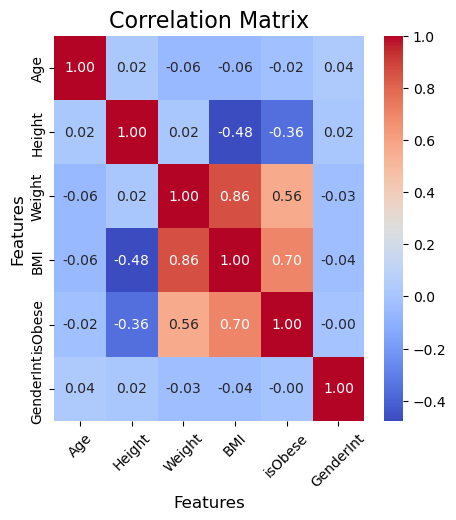

In [263]:
num_cols = obesity_data.select_dtypes(include=np.number).columns
corr_matrix = obesity_data[num_cols].corr()

fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

ax.set_title("Correlation Matrix", fontsize=16)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

plt.show()

<Axes: xlabel='BMI', ylabel='ObesityCategoryInt'>

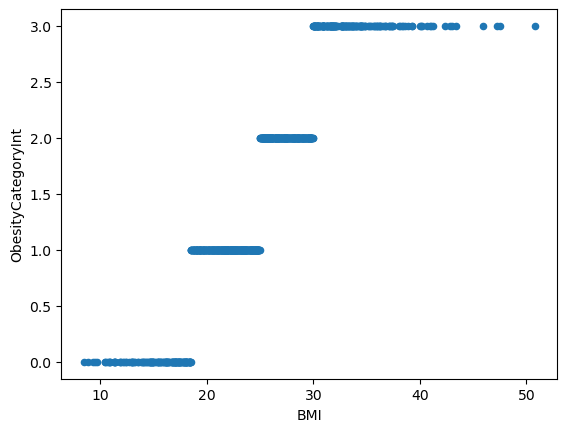

In [141]:
obesity_data.plot.scatter(x='BMI', y='ObesityCategoryInt')

# Convert to binary classification problem

In [144]:
obesity_data['isObese'] = obesity_data['ObesityCategoryInt'] >= 3
obesity_data.drop(columns = ['ObesityCategory', 'ObesityCategoryInt', 'PhysicalActivityLevel'], inplace=True)

In [146]:
obesity_data['GenderInt'] = obesity_data['Gender'].map(lambda g: 1 if g == 'Male' else 0)

In [148]:
obesity_data.drop(columns = ['Gender'], inplace=True)

In [150]:
obesity_data['isObese'] = obesity_data['isObese'].apply(lambda o: 1 if o else 0)

In [152]:
obesity_data.head()

,Age,Height,Weight,BMI,isObese,GenderInt
0,56,173.575262,71.982051,23.891783,0,1
1,69,164.127306,89.959256,33.395209,1,1
2,46,168.072202,72.930629,25.817737,0,0
3,32,168.459633,84.886912,29.912247,0,1
4,60,183.568568,69.038945,20.487903,0,1


# Functions

In [175]:
def get_metrics_for_model(model, x_test, y_test, x_train, y_train, is_lstm):

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    if not is_lstm:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
    else:
        model.fit(x_train_scaled, y_train.values, epochs=50, verbose=False)
        y_pred_proba = model.predict(x_test_scaled)
        y_pred = y_pred_proba > 0.5
        
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])
    metrics = calculate_metrics(conf_matrix)

    return metrics

In [195]:
def create_model(model_name):
    if model_name == 'knn':
        model = KNeighborsClassifier()
    elif model_name == 'random_forest':
        model = RandomForestClassifier()
    elif model_name == 'lstm':
        model = Sequential()
        model.add(LSTM(16, activation='relu', batch_input_shape=(None, 5, 1), return_sequences=False))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        raise "Unknown model"

    return model

# Model

In [198]:
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=121)

In [241]:
X = obesity_data.copy(deep=True)
y = X.pop('isObese')
results = []
for iter_, (train_index, test_index) in enumerate(cv_stratified.split(X, y)):
    print('Iteration ', iter_)
    x_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    x_train = X.iloc[train_index]
    y_train = y.iloc[train_index]

    all_metrics = []
    for model_name in ['knn', 'random_forest', 'lstm']:
        model = create_model(model_name)
        if model_name == 'lstm':
            is_lstm = True
        else:
            is_lstm = False
        metrics = get_metrics_for_model(model, x_test, y_test, x_train, y_train, is_lstm) 
        metrics = pd.Series(metrics)
        metrics.name = model_name
        all_metrics.append(metrics)

    print('Results for Iteration ', iter_)
    result = pd.concat(all_metrics, axis=1).T
    results.append(result)
    print(result)
    print('*******************************************************************')

Iteration  0
4/4 [==============================] - 0s 5ms/step
Results for Iteration  0
                 TP    TN   FP   FN       TPR       TNR       FPR       FNR  \
knn            17.0  79.0  2.0  2.0  0.894737  0.975309  0.024691  0.105263   
random_forest  19.0  81.0  0.0  0.0  1.000000  1.000000  0.000000  0.000000   
lstm           19.0  80.0  1.0  0.0  1.000000  0.987654  0.012346  0.000000   

               Precision  F1_measure  Accuracy  Error_rate      BACC  \
knn             0.894737    0.894737      0.96        0.04  0.935023   
random_forest   1.000000    1.000000      1.00        0.00  1.000000   
lstm            0.950000    0.974359      0.99        0.01  0.993827   

                    TSS       HSS  
knn            0.870045  0.870045  
random_forest  1.000000  1.000000  
lstm           0.987654  0.968153  
*******************************************************************
Iteration  1
4/4 [==============================] - 0s 3ms/step
Results for Iteration  1
    

In [255]:
def get_average_of_all_iterations(results):
    avg_result = results[0]
    if len(results) == 1:
        return avg_result
    for i in range(1, len(results)):
        avg_result = avg_result + results[i]
    
    avg_result = avg_result / len(results)
    return avg_result

In [257]:
get_average_of_all_iterations(results)

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1_measure,Accuracy,Error_rate,BACC,TSS,HSS
knn,16.9,80.0,0.9,2.2,0.885000,0.988889,0.011111,0.115000,0.952446,0.915086,0.969,0.031,0.936944,0.873889,0.896233
random_forest,19.0,80.8,0.1,0.1,0.994737,0.998765,0.001235,0.005263,0.995000,0.994733,0.998,0.002,0.996751,0.993502,0.993500
lstm,18.3,80.6,0.3,0.8,0.958421,0.996296,0.003704,0.041579,0.984181,0.970543,0.989,0.011,0.977359,0.954717,0.963791
